In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Import from scripts
sys.path.append("..") 
from src.data_loader import load_tsla_data
from scripts.lstm import preprocess_data, build_lstm_model,train_lstm, forecast_lstm,evaluate_lstm, plot_lstm_results
                 
                 

In [3]:
data = load_tsla_data('../data/TSLA_cleaned.csv')  



2025-03-01 22:46:03,857 - INFO - Loading TSLA data from CSV...
2025-03-01 22:46:03,889 - INFO - Verifying TSLA data integrity...
2025-03-01 22:46:03,893 - INFO - TSLA data loaded successfully. Shape: (2505, 9), Missing values: 0


In [4]:
data = data.asfreq('B').ffill()
data.head() 

,Price,Close,High,Low,Volume,Daily_Return,Rolling_Mean,Rolling_Std,Z_Score
Date,,,,,,,,,
2015-02-17,13.623333,13.713333,13.433333,13.713333,59694000.0,-0.140787,13.940933,0.583636,-0.895868
2015-02-18,13.630667,13.744667,13.506667,13.611333,40704000.0,0.228492,13.917978,0.577107,-0.895605
2015-02-19,14.114000,14.162667,13.583333,13.666667,77311500.0,3.041181,13.914067,0.574963,-0.892099
2015-02-20,14.474000,14.506667,13.987333,14.052000,89731500.0,2.428920,13.920333,0.580523,-0.889213
2015-02-23,13.822667,14.546667,13.755333,14.377333,127497000.0,0.275735,13.930111,0.588737,-0.888878


In [5]:
#Split data
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [6]:
# Preprocess and train
X_train, y_train, scaler = preprocess_data(train_data)
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
trained_model, history = train_lstm(model, X_train, y_train)

2025-03-01 22:46:18,637 - INFO - Preprocessing data for LSTM
2025-03-01 22:46:18,650 - INFO - Created 2018 sequences with 60 time steps
2025-03-01 22:46:18,653 - INFO - Building LSTM model
c:\Users\HP\Documents\Dagii\week-11\TimeSeries-Portfolio-Optimization\week-11\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

2025-03-01 22:46:19,000 - INFO - Model summary:
None
2025-03-01 22:46:19,003 - INFO - Starting model training


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0193
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.9407e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0011
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.9211e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.0782e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 7.3160e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 6.2653e-04
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5.8728e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.4369e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.1165e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.1135e-04
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.9830e-04
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.9792e-04
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.2678e-04
Epoch 15/

2025-03-01 22:49:43,350 - INFO - Training stopped at epoch 64


In [7]:
# Generate and evaluate forecasts
predictions = forecast_lstm(trained_model, train_data[['Close']], scaler)
valid = test_data.copy()
valid['Predictions'] = predictions[-len(test_data):]

2025-03-01 22:49:43,367 - INFO - Generating forecasts


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

2025-03-01 22:55:33,508 - INFO - Generated 2018 forecasts


2025-03-01 22:55:33,529 - INFO - Evaluating LSTM performance
2025-03-01 22:55:33,541 - INFO - LSTM Evaluation - MAE: 296.10, RMSE: 303.87, MAPE: 124.45%
2025-03-01 22:55:33,543 - INFO - Generating results plot


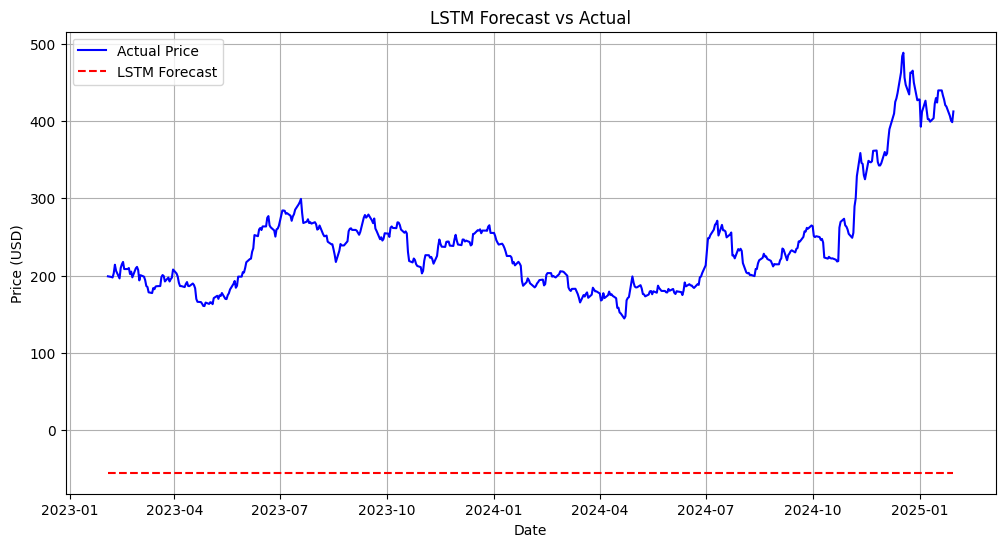

2025-03-01 22:55:33,954 - INFO - Plot generated successfully


In [8]:
evaluate_lstm(valid['Close'].dropna(), valid['Predictions'].dropna())
plot_lstm_results(valid['Close'], valid['Predictions'].dropna())